In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve


* Carga de dataset

In [2]:
data = pd.read_csv('../../../data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


* Exploracion inicial

In [3]:
print("Primeras filas del dataset:")
print(data.head())
print("\nInformación general del dataset:")
print(data.info())
print("\nResumen estadístico:")
print(data.describe())

Primeras filas del dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Resumen estadístico:
       

* Identificar valores faltantes y outliers


Valores faltantes:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


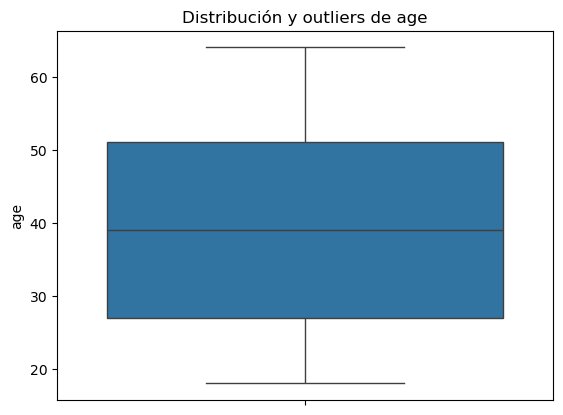

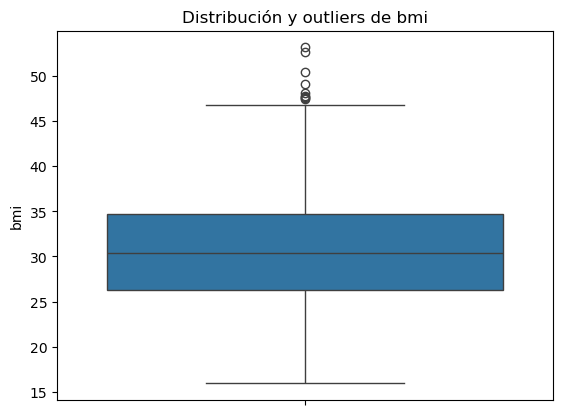

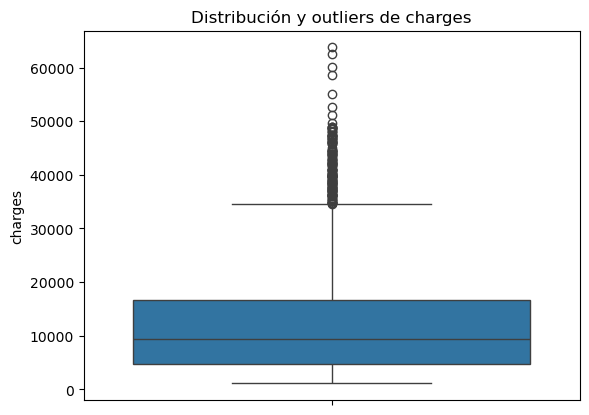

In [4]:
print("\nValores faltantes:")
print(data.isnull().sum())

# Identificación de outliers
for column in ['age', 'bmi', 'charges']:
    sns.boxplot(data[column])
    plt.title(f'Distribución y outliers de {column}')
    plt.show()

* Preprocesamiento de datos

In [5]:
# Imputación de valores faltantes (si aplica)
# (En este caso no hay valores faltantes, por lo que este paso no es necesario)
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_7760\2719275331.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].mean(), inplace=True)


* Codificacion de variables categoricas

In [6]:
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)

# Escalado de características numéricas
scaler = StandardScaler()
data[['age', 'bmi', 'charges']] = scaler.fit_transform(data[['age', 'bmi', 'charges']])

* Implementacion de modelos de clasificacion

In [7]:
# Definición de variables independientes y dependiente
X = data.drop(columns=['smoker_yes'])
y = data['smoker_yes']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento y evaluación inicial de modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

print("\nResultados de validación cruzada inicial:")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")


Resultados de validación cruzada inicial:
Logistic Regression: Mean Accuracy = 0.9514
KNN: Mean Accuracy = 0.9327
Decision Tree: Mean Accuracy = 0.9570


* Optimizacion con Hiperparametros

In [8]:
# GridSearchCV para KNN
param_grid = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("\nMejor parámetro KNN (GridSearchCV):", grid_search.best_params_)

# RandomizedSearchCV para KNN
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_iter=10, random_state=42)
random_search.fit(X_train, y_train)
print("Mejor parámetro KNN (RandomizedSearchCV):", random_search.best_params_)


Mejor parámetro KNN (GridSearchCV): {'n_neighbors': 3}
Mejor parámetro KNN (RandomizedSearchCV): {'n_neighbors': 1}


* Evaluacion de modelos


Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       214
        True       0.86      0.93      0.89        54

    accuracy                           0.96       268
   macro avg       0.92      0.94      0.93       268
weighted avg       0.96      0.96      0.96       268

ROC-AUC: 0.9764624437521634


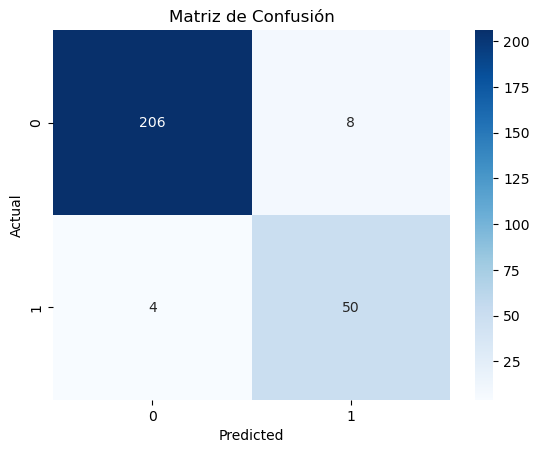

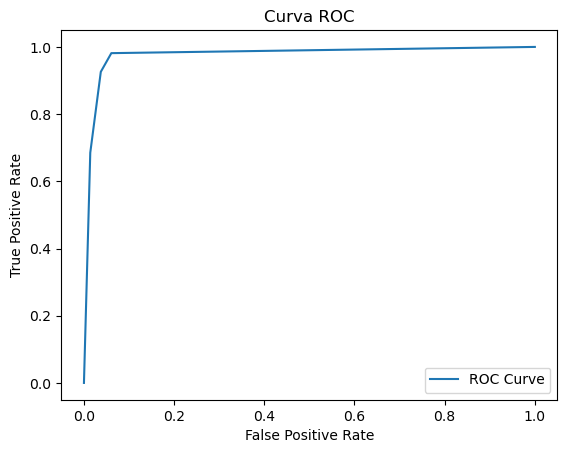

In [9]:

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluación de métricas de rendimiento
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()